In [1]:
import numpy as np
import wfdb
from DATA import *
import os
import matplotlib.pyplot as plt
from wfdb.processing import find_peaks
import pandas as pd
import glob
import math
from sklearn import preprocessing
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, resample
from sklearn.metrics import confusion_matrix 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(signal, fs, cutoff=50):
    # Define filter parameters
    order = 5

    # Create the lowpass Butterworth filter
    b, a = butter_lowpass(cutoff, fs, order=order)

    # Apply the filter to the signal using zero-phase filtering (filtfilt)
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal


def plot_confusion_matrix(y_true, y_pred, title, Y_lbl, cmap = plt.cm.Blues):
    classes = np.unique(Y_lbl)
    labels = range(len(classes))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm2 = np.round(cm/cm.sum(axis=1)[:,None]*100, decimals=1)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm2, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
    plt.title(title+" confusion matrix", fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, cm2[i, j],
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    plt.show()
def evaluation(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP 
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = []

    for i in range(confusion_matrix.shape[1]):
        temp = np.delete(confusion_matrix, i, 0)    # delete ith row\n",
        temp = np.delete(temp, i, 1)  # delete ith column\
        TN.append(sum(sum(temp)))

        accuracy = np.round((TP+TN)/(TP+TN+FP+FN)*100, 2)
        specificity = np.round(TN/(TN+FP)*100,2)
        recall = np.round(TP/(TP+FN)*100, 2)
        
        df_column_names = ['Accuracy (%)','Specificity (%)','Sensit/Recall (%)']
        df_row_names = ['F','N','S','V']
        evaluation = pd.DataFrame(np.concatenate((accuracy.reshape(-1,1),
                                                  specificity.reshape(-1,1),
                                                  recall.reshape(-1,1)),axis=1),
                                                  index=df_row_names, columns=df_column_names)
        return evaluation
#Find AAMI classes

def which_class(x):
    if np.isin(x,N): return 'N'
    elif np.isin(x,S): return 'S'
    elif np.isin(x,V): return 'V'
    elif np.isin(x,F): return 'F'
    else: return 'none'

#definition of AAMI classes
N = ['.','N','L','R','e','j','n'];
S = ['A','a','J','S'];
V = ['V','E','r'];
F = ['F'];


In [2]:
complete_data = pd.DataFrame()

half_qrs = 210 #Single beat segmentation -> initial beat length: 420pt
pts = 320 #Triple beat segmentation -> beat length: 320pt
count = 0
maximum = 60
database = 'eu_db'
sampling_rate = 250
lead = []
# Define the cutoff frequency
cutoff_freq = 100  # Hz
# Define the filter order
filter_order = 4
# Calculate the normalized cutoff frequency
nyquist_freq = 0.5 * 360  # The Nyquist frequency is half the sampling rate
normalized_cutoff_freq = cutoff_freq / nyquist_freq
# Define the number of samples to use for padding
padlen = 1

#Beat selection from Physionet beats annotation guidlines
good_beats = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r','F', 'e', 'j', 'n', 'E']

for filename in os.listdir(database):
    if count < maximum:
        if filename.endswith(".dat"):
            ann = wfdb.rdann(database + '/' + filename.strip('.dat'), 'atr')
            record = wfdb.rdsamp(database + '/' + filename.strip('.dat'))
            record_num = filename.strip('.dat')
            
            #Signals
            data = record[0]
            info = record[1]
            lead.append(info["sig_name"])
            resampling_factor = 360 / sampling_rate
            resampled_signal = scipy.signal.resample(data, int(len(data) * resampling_factor))
        
            # Design the filter coefficients
            b, a = butter(filter_order, normalized_cutoff_freq, btype='lowpass')

            # Apply the filter to the resampled ECG signal
            filtered_signal = filtfilt(b, a, resampled_signal, padlen=padlen)

            data = filtered_signal
            
            signals1, signals2, classes, signals3 = [], [], [], []
            
            #Beat extraction
            for it, beat in enumerate(ann.symbol):
                if it>0:
                    if beat in good_beats:
                        
                        new_annotation = int(ann.sample[it] * (360 / sampling_rate))
                        new_annotation_prev = int(ann.sample[it-1] * (360 / sampling_rate))
                        #new_annotation = ann.sample[it]
                        #new_annotation_prev = ann.sample[it-1]

                        #Single beat extraction
                        sta1 = new_annotation - half_qrs
                        end1 = new_annotation + half_qrs
                        qrs1 = data[sta1 : end1, :]
                        
                        #Triple beat extraction
                        sta2 = math.floor((new_annotation + new_annotation_prev)/2)
                        end2 = sta2 + pts
                        qrs2 = data[sta2 : end2, :]
                        
                        #Avoid problems at the edges
                        if len(qrs1) != 2 * half_qrs: continue
                        if end2 > len(data[:,0]): continue

                        curr_beat1 = qrs1.reshape(half_qrs*2,2)
                        curr_beat2 = qrs2.reshape(pts,2)
                        signals1.append(curr_beat1)
                        signals2.append(curr_beat2)
                        classes.append(beat)

            #Triple beat arrangement
            for i in range(1,len(signals2)-1):
                temp = np.hstack((signals2[i-1],signals2[i],signals2[i+1]))
                signals3.append(temp)
                temp=0
                
            #Single and triple beat consistency
            signals1.pop(0)
            signals1.pop(-1)
            classes.pop(0)
            classes.pop(-1)
            
            
            #Obtained data 
            frame = pd.DataFrame({'beat' : signals1,
                                '3beat' : signals3,
                                'label' : classes,
                                'record' : record_num})

            complete_data = complete_data.append(frame)
            count = count + 1

In [3]:
#Single beat
df = complete_data
test = df['beat'].values
testX = np.vstack(test).reshape(test.shape[0],half_qrs*2,2)
testX_1beat = np.zeros((testX.shape[0], 320, 2))
for i in range(testX_1beat.shape[0]):
    sta = np.random.choice(range(0,100))
    end = sta + 320
    testX_1beat[i,:,:] = testX[i, sta:end, :]
#mean_vals = np.mean(testX_1beat, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
#testX_1beat = testX_1beat - mean_vals


In [4]:
#Triple beat
beats_3 = df['3beat'].values
testX_3beat = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #
mean_vals = np.mean(testX_3beat, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
testX_3beat = testX_3beat - mean_vals 

In [4]:
#MIT annotations
labels = complete_data['label'].values
testY_lbl = np.array([which_class(x) for x in labels])
testY_int = label_encoder.transform(testY_lbl)

In [ ]:
np.unique(testY_lbl,return_counts=True)

(array(['F', 'N', 'S', 'V'], dtype='<U1'),
 array([   351, 698575,   1072,   4447]))

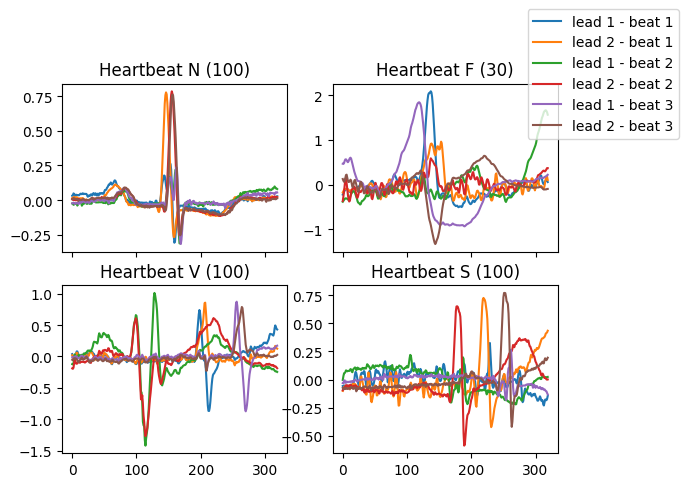

In [ ]:
import matplotlib.pyplot as plt

N = np.where(testY_lbl=='N')
S = np.where(testY_lbl=='S')
F = np.where(testY_lbl=='F')
V = np.where(testY_lbl=='V')

indx_N = N[0][100]
indx_F = F[0][30]
indx_V = V[0][100]
indx_S = S[0][100]

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(testX_3beat[indx_N][:,0], label = "lead 1 - beat 1")
ax[0,0].plot(testX_3beat[indx_N][:,1], label = "lead 2 - beat 1")
ax[0,0].plot(testX_3beat[indx_N][:,2], label = "lead 1 - beat 2")
ax[0,0].plot(testX_3beat[indx_N][:,3], label = "lead 2 - beat 2")
ax[0,0].plot(testX_3beat[indx_N][:,4], label = "lead 1 - beat 3")
ax[0,0].plot(testX_3beat[indx_N][:,5], label = "lead 2 - beat 3")
ax[0,1].plot(testX_3beat[indx_F])
ax[1,0].plot(testX_3beat[indx_V])
ax[1,1].plot(testX_3beat[indx_S])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

ax[0,0].set_title('Heartbeat N (100)')
ax[0,1].set_title('Heartbeat F (30)')
ax[1,0].set_title('Heartbeat V (100)')
ax[1,1].set_title('Heartbeat S (100)')

plt.show()

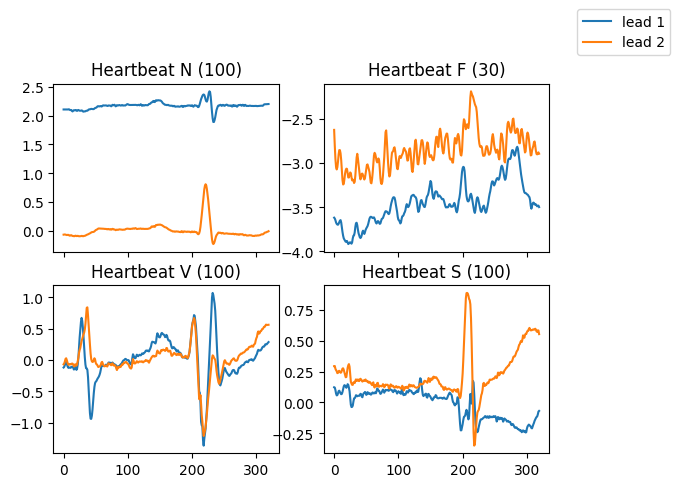

In [5]:
import matplotlib.pyplot as plt

N = np.where(testY_lbl=='N')
S = np.where(testY_lbl=='S')
F = np.where(testY_lbl=='F')
V = np.where(testY_lbl=='V')

indx_N = N[0][100]
indx_F = F[0][30]
indx_V = V[0][100]
indx_S = S[0][100]

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(testX_1beat[indx_N][:,0], label = "lead 1")
ax[0,0].plot(testX_1beat[indx_N][:,1], label = "lead 2")
ax[0,1].plot(testX_1beat[indx_F])
ax[1,0].plot(testX_1beat[indx_V])
ax[1,1].plot(testX_1beat[indx_S])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

ax[0,0].set_title('Heartbeat N (100)')
ax[0,1].set_title('Heartbeat F (30)')
ax[1,0].set_title('Heartbeat V (100)')
ax[1,1].set_title('Heartbeat S (100)')

plt.show()

1/1 [==============================] - 0s 260ms/step


Text(0.5, 1.0, 'Heartbeat S ')

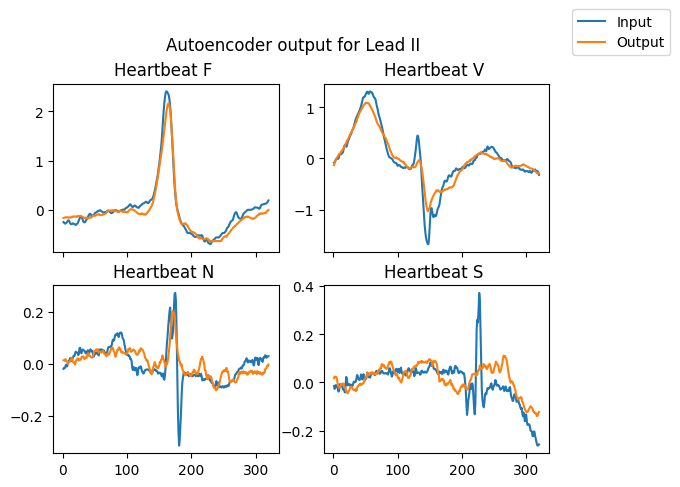

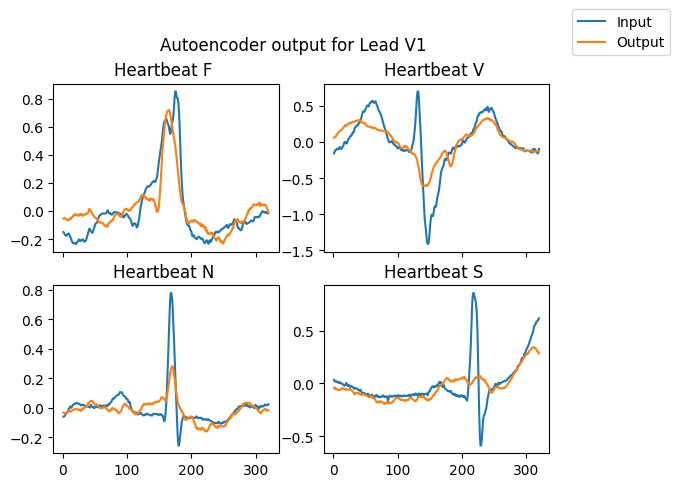

In [22]:
import keras
from keras.models import load_model

autoencoder_1beat_residual_MODEL = load_model("autoencoder_1beat_residual_MODEL")
lbls = np.unique(testY_lbl)

F_index_test = np.where(testY_lbl == lbls[0])[0].astype(int)
N_index_test = np.where(testY_lbl == lbls[1])[0].astype(int)
S_index_test = np.where(testY_lbl == lbls[2])[0].astype(int)
V_index_test = np.where(testY_lbl == lbls[3])[0].astype(int)

lbl_index_test = np.array([])
i = 29
lbl_index_test = np.append(lbl_index_test,F_index_test[i])
lbl_index_test = np.append(lbl_index_test,N_index_test[i])
lbl_index_test = np.append(lbl_index_test,S_index_test[i])
lbl_index_test = np.append(lbl_index_test,V_index_test[i])

lbl_index_test = lbl_index_test.astype(int)
representations_test = autoencoder_1beat_residual_MODEL.predict(testX_1beat[lbl_index_test,:,:])
true_values_test = testX_1beat[lbl_index_test,:,:]

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(range(1,321), true_values_test[0,:,0], label = "Input")
ax[0,0].plot(range(1,321), representations_test[0,:,0], label = "Output")
ax[1,0].plot(range(1,321), true_values_test[1,:,0])
ax[1,0].plot(range(1,321), representations_test[1,:,0])
ax[1,1].plot(range(1,321), true_values_test[2,:,0])
ax[1,1].plot(range(1,321), representations_test[2,:,0])
ax[0,1].plot(range(1,321), true_values_test[3,:,0])
ax[0,1].plot(range(1,321), representations_test[3,:,0])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

fig.suptitle('Autoencoder output for Lead II')

ax[0,0].set_title('Heartbeat F ')
ax[0,1].set_title('Heartbeat V ')
ax[1,0].set_title('Heartbeat N ')
ax[1,1].set_title('Heartbeat S ')

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(range(1,321), true_values_test[0,:,1], label = "Input")
ax[0,0].plot(range(1,321), representations_test[0,:,1], label = "Output")
ax[1,0].plot(range(1,321), true_values_test[1,:,1])
ax[1,0].plot(range(1,321), representations_test[1,:,1])
ax[1,1].plot(range(1,321), true_values_test[2,:,1])
ax[1,1].plot(range(1,321), representations_test[2,:,1])
ax[0,1].plot(range(1,321), true_values_test[3,:,1])
ax[0,1].plot(range(1,321), representations_test[3,:,1])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

fig.suptitle('Autoencoder output for Lead V1')

ax[0,0].set_title('Heartbeat F ')
ax[0,1].set_title('Heartbeat V ')
ax[1,0].set_title('Heartbeat N ')
ax[1,1].set_title('Heartbeat S ')

16604/16604 [==============================] - 7s 427us/step


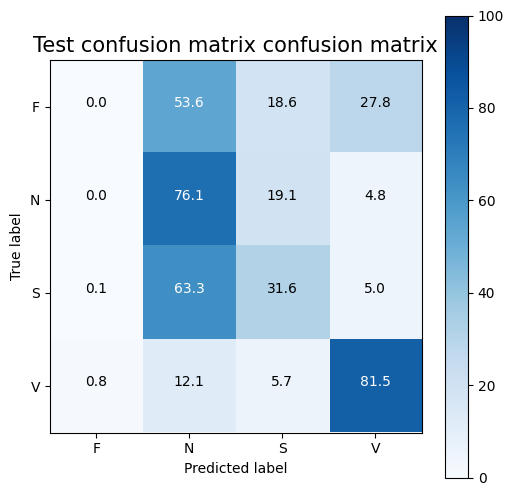

,Accuracy (%),Specificity (%),Sensit/Recall (%)
F,99.90,99.97,0.00
N,88.00,99.75,76.11
S,83.96,84.05,31.56
V,95.37,95.47,81.46


In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

predicted_labels = np.empty(np.shape(testY_lbl))

#Single beat classifier
classifier_1beat = load_model("classifier_1beat_residual_MODEL")
predicted_1beat = classifier_1beat.predict(testX_1beat)
predicted_1beat = predicted_1beat.argmax(axis=-1)

#Triple beat classifier
encoder_3beat = load_model("encoder_3beat_residual_MODEL")
classifier_3beat = load_model("classifier_3beat_residual_MODEL")
feature_vector_test_3beat = encoder_3beat.predict(testX_3beat)
predicted_3beat = classifier_3beat.predict(feature_vector_test_3beat)
predicted_3beat = predicted_3beat.argmax(axis=-1) 

#Classifiers combination
for i in range(0,len(predicted_labels)): # Only predictions of 3 beats is selected unless the heartbeat is labelled N  
    if predicted_1beat[i] == 3: 
        predicted_labels[i] = predicted_1beat[i]
    else:
        predicted_labels[i] = predicted_3beat[i]

 #Confusion matrix
import itertools

plot_confusion_matrix(testY_int, predicted_labels, "Test confusion matrix", testY_lbl)
cm = confusion_matrix(testY_int, predicted_labels)
Eval = evaluation(cm)
display(Eval)